# SNiFi: Support Vector Machine Model in Binary Classification

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

RANDOM_STATE = 42
N_ESTIMATORS = 10
MAX_SAMPLES = 0.1
N_JOBS = -1

ML_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATASET_DIRECTORY = os.path.join(ML_DIR, 'data', 'production', 'csv')
MODEL_PATH = os.path.join(ML_DIR, 'models', 'svm_bagging_model_v1.0.0.pkl')

X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight'
]
y_column = 'label'

df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets) * 0.8)]
test_sets = df_sets[int(len(df_sets) * 0.8):]

dict_2classes = {
    'DDoS-RSTFINFlood': 'Attack',
    'DDoS-PSHACK_Flood': 'Attack',
    'DDoS-SYN_Flood': 'Attack',
    'DDoS-UDP_Flood': 'Attack',
    'DDoS-TCP_Flood': 'Attack',
    'DDoS-ICMP_Flood': 'Attack',
    'DDoS-SynonymousIP_Flood': 'Attack',
    'DDoS-ACK_Fragmentation': 'Attack',
    'DDoS-UDP_Fragmentation': 'Attack',
    'DDoS-ICMP_Fragmentation': 'Attack',
    'DDoS-SlowLoris': 'Attack',
    'DDoS-HTTP_Flood': 'Attack',
    'DoS-UDP_Flood': 'Attack',
    'DoS-SYN_Flood': 'Attack',
    'DoS-TCP_Flood': 'Attack',
    'DoS-HTTP_Flood': 'Attack',
    'Mirai-greeth_flood': 'Attack',
    'Mirai-greip_flood': 'Attack',
    'Mirai-udpplain': 'Attack',
    'Recon-PingSweep': 'Attack',
    'Recon-OSScan': 'Attack',
    'Recon-PortScan': 'Attack',
    'VulnerabilityScan': 'Attack',
    'Recon-HostDiscovery': 'Attack',
    'DNS_Spoofing': 'Attack',
    'MITM-ArpSpoofing': 'Attack',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Attack',
    'Backdoor_Malware': 'Attack',
    'XSS': 'Attack',
    'Uploading_Attack': 'Attack',
    'SqlInjection': 'Attack',
    'CommandInjection': 'Attack',
    'DictionaryBruteForce': 'Attack'
}

scaler = StandardScaler()
for train_set in tqdm(training_sets):
    file_path = os.path.join(DATASET_DIRECTORY, train_set)
    scaler.fit(pd.read_csv(file_path)[X_columns])

base_svc = SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE)

bagging_svc = BaggingClassifier(
    estimator=base_svc,
    n_estimators=N_ESTIMATORS,
    max_samples=MAX_SAMPLES,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

for train_set in tqdm(training_sets):
    file_path = os.path.join(DATASET_DIRECTORY, train_set)
    train_data = pd.read_csv(file_path)
    train_data[X_columns] = scaler.transform(train_data[X_columns])
    train_data[y_column] = [dict_2classes[k] for k in train_data[y_column]]

    bagging_svc.fit(train_data[X_columns], train_data[y_column])

joblib.dump(bagging_svc, MODEL_PATH)

y_test = []
y_pred = []

for test_set in tqdm(test_sets):
    file_path = os.path.join(DATASET_DIRECTORY, train_set)
    test_data = pd.read_csv(file_path)
    test_data[X_columns] = scaler.transform(test_data[X_columns])
    test_data[y_column] = [dict_2classes[k] for k in test_data[y_column]]

    y_test.extend(test_data[y_column].values)
    y_pred.extend(bagging_svc.predict(test_data[X_columns]))

print('##### Support Vector Machine (Bagging, 2 classes) #####')
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Recall Score: ', recall_score(y_test, y_pred, average='macro'))
print('Precision Score: ', precision_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

class_counts = Counter(y_test)
print("\nClass Imbalance:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

100%|██████████| 34/34 [11:04<00:00, 19.55s/it]


##### Support Vector Machine (Bagging, 2 classes) #####
Accuracy Score:  0.9899088611869776
Recall Score:  0.8675460023051338
Precision Score:  0.9042781801281389
F1 Score:  0.8849898292413498

Class Imbalance:
Attack: 10096839
Benign: 243322


In [2]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)
print("\n\n")

Confusion Matrix:
 [[10055968    40871]
 [   63473   179849]]





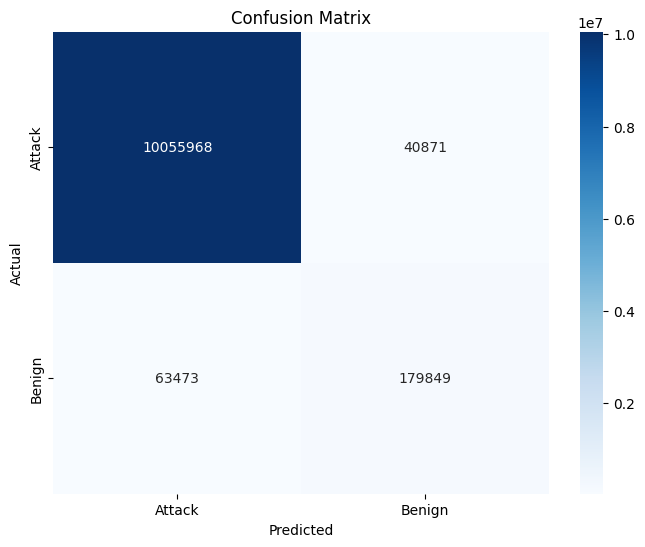

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Attack', 'Benign']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Overall Effectiveness of the SVM Model (Metric: *accuracy*)
* The model rarely makes mistakes.
* In **98.99%** of cases, it correctly identifies the type of traffic (**attack** or **normal traffic**).

### How Well the Model Detects Attacks (Metric: *Recall*)
* The model is highly capable of identifying attack attempts, with a recall of over **86%**.

### How Well the Model Avoids False Alarms (Metric: *Precision*)
* The model performs very well in avoiding false alarms, with a precision of over **90%**.

### Balance Between Detection and Avoiding False Alarms (Metric: *F1 Score*)
* The **F1 score**, which helps understand how well the model balances detecting attacks and avoiding false alarms, is over **88%**.
* This high F1 score indicates a strong balance between these two aspects: the model is equally good at detecting attacks and avoiding false alarms.

### Confusion Matrix Analysis
The confusion matrix shows how often the model makes errors or is accurate in its predictions. For this model:
* **Correctly** identified **10,055,968** attacks as threats <-- **True Positives (TP)**.
* **Incorrectly** identified **63,473** benign activities as attacks (false alarms) <-- **False Positives (FP)**.
* **Incorrectly** classified **40,871** attacks as safe activities (these are misses) <-- **False Negatives (FN)**.
* **Correctly** recognized **179,849** benign activities as safe activities <-- **True Negatives (TN)**.